# Setup use case Wine 

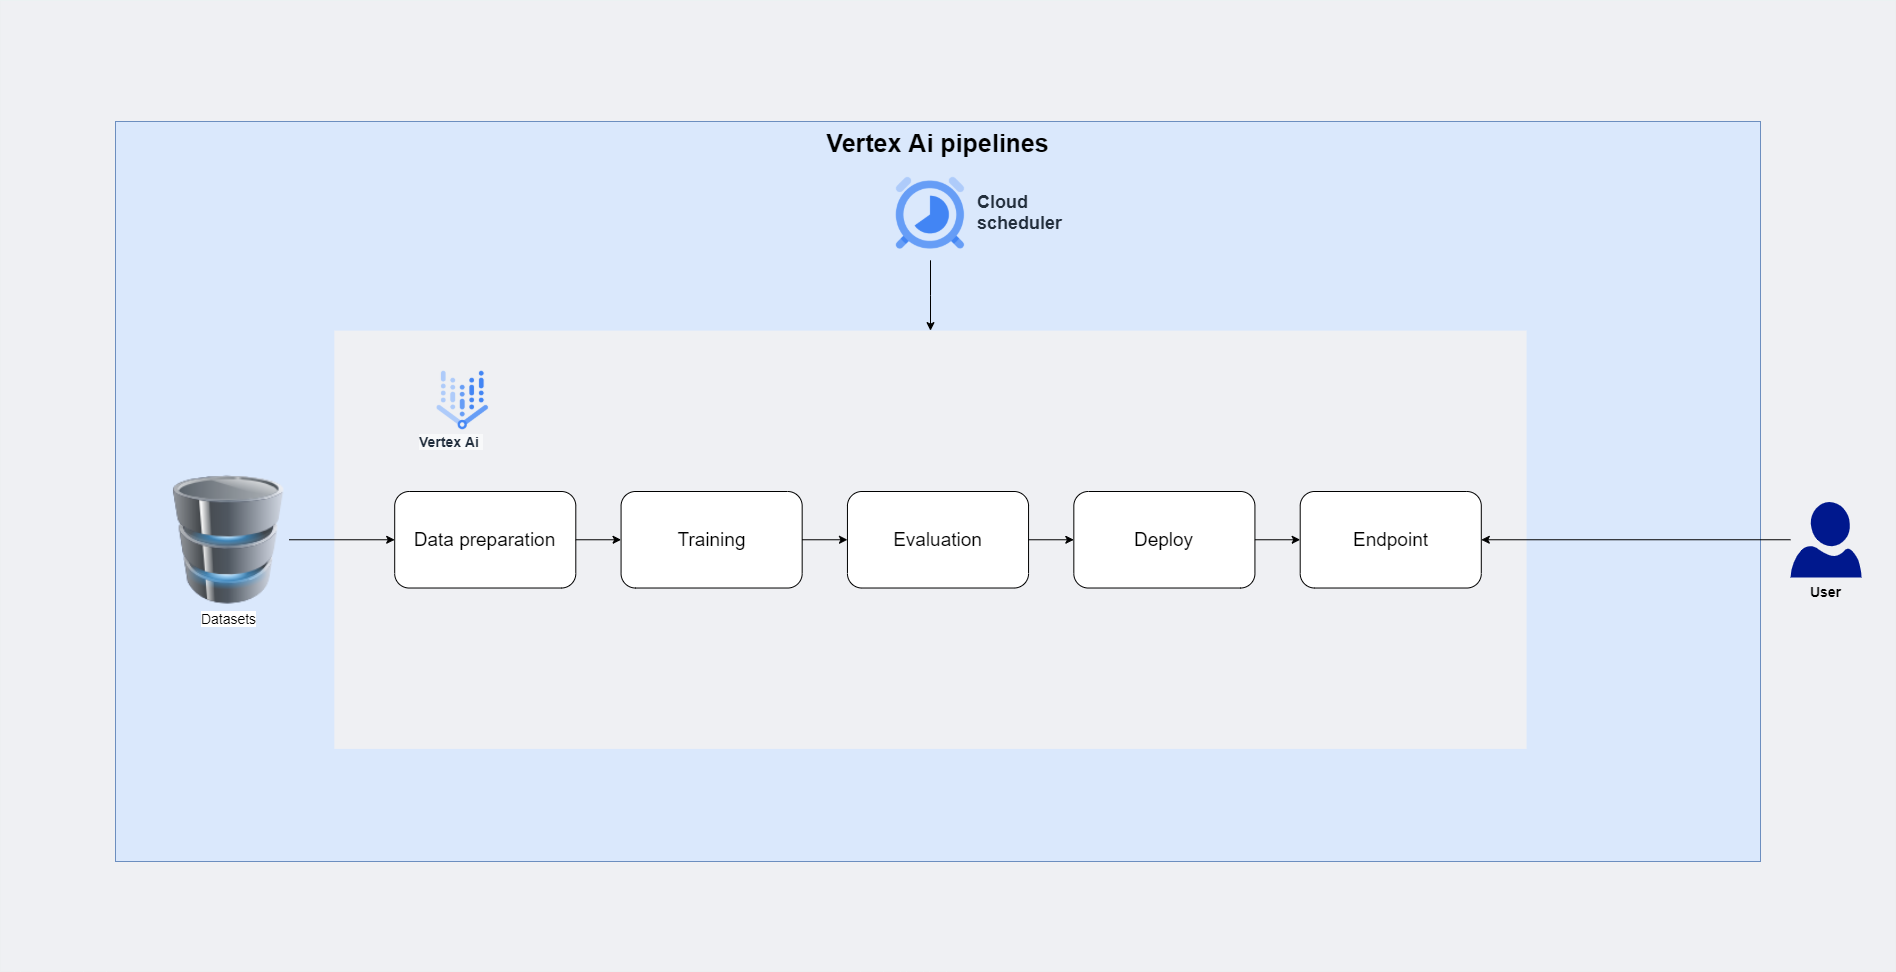

In [2]:
import requests
from io import BytesIO
from IPython.display import Image, display
from PIL import Image as pil_image

file_url = 'https://psitron.s3.ap-southeast-1.amazonaws.com/Machine+Learning+Operations+(MLOps)+Specialization+Course+Jan+2023/GCP+vertex+ai+piplines.png'
response = requests.get(file_url)
pil_img = pil_image.open(BytesIO(response.content)).convert('RGB')

display(pil_img)

### Set up the auto completion

In [18]:
#install auto-completion 
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
from jedi import settings
settings.case_insensitive_completion = True

[I 10:01:23 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 10:01:23 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 10:01:23 InstallContribNbextensionsApp] Installing /opt/conda/lib/python3.7/site-packages/jupyter_contrib_nbextensions/nbextensions/hide_input -> hide_input
[I 10:01:23 InstallContribNbextensionsApp] Up to date: /home/jupyter/.local/share/jupyter/nbextensions/hide_input/hide-input.yaml
[I 10:01:23 InstallContribNbextensionsApp] Up to date: /home/jupyter/.local/share/jupyter/nbextensions/hide_input/icon.png
[I 10:01:23 InstallContribNbextensionsApp] Up to date: /home/jupyter/.local/share/jupyter/nbextensions/hide_input/readme.md
[I 10:01:23 InstallContribNbextensionsApp] Up to date: /home/jupyter/.local/share/jupyter/nbextensions/hide_input/main.js
[I 10:01:23 InstallContribNbextensionsApp] - Validating: OK
[I 10:01:23 InstallContribNbextensionsApp] Installing /opt/conda/lib

### Set up the environment 
- Python 3
- virtualenv
- Jupyter notebook running in a virtual environment with Python 3
- Docker
- Git
- Google Cloud SDK (gcloud)

### Enable  the APIs if they are not enabled 

In [19]:
!gcloud services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com  \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com


Operation "operations/acat.p2-531751153412-629a5d8a-d702-4d60-9ed7-6b37e2cff4cb" finished successfully.


## Uncomment all needed cells if you need to install missing packages 

In [20]:
# Install ai platform and kfp
USER_FLAG = "--user"
!pip3 install {USER_FLAG} google-cloud-aiplatform==1.3.0 --upgrade
!pip3 install {USER_FLAG} kfp --upgrade

  Using cached google_cloud_aiplatform-1.3.0-py2.py3-none-any.whl (1.3 MB)
  Using cached google_cloud_storage-1.44.0-py2.py3-none-any.whl (106 kB)
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.7.0
    Uninstalling google-cloud-storage-2.7.0:
      Successfully uninstalled google-cloud-storage-2.7.0
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 1.23.0
    Uninstalling google-cloud-aiplatform-1.23.0:
      Successfully uninstalled google-cloud-aiplatform-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-pipeline-components 1.0.40 requires google-cloud-aiplatform<2,>=1.14.0, but you have google-cloud-aiplatform 1.3.0 which is incompatible.
google-cloud-pipeline-components 1.0.40 requires google-cloud-storage<3,>=2.2.1, but you have g

In [ ]:
!pip install google-cloud-pipeline-components --user

In [6]:
# Restart the kernel
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)


#### Set up the global variables 

In [4]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="europe-west1"

# Get projet name
shell_output=!gcloud config get-value project 2> /dev/null
PROJECT_ID=shell_output[0]

# Set bucket name
BUCKET_NAME="gs://"+PROJECT_ID+"-bucket-winequality"

# Create bucket
PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root_wine/"
PIPELINE_ROOT

USER_FLAG = "--user"


env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:/home/jupyter/.local/bin


## Import Libraries
 * Artifact,
 * Dataset,
 * Input,
 * Model,
 * Output,
 * Metrics,
 * ClassificationMetrics
 * InputPath
 * OutputPath

In [5]:
from typing import NamedTuple
import typing
from kfp.v2 import dsl
from kfp.v2.dsl import (Artifact,
                        Dataset,
                        Input,
                        Model,
                        Output,
                        Metrics,
                        ClassificationMetrics,
                        component, 
                        OutputPath, 
                        InputPath)

from kfp.v2 import compiler
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs
from google_cloud_pipeline_components import aiplatform as gcc_aip



### Create pipeline

We create 4 components:  
- Load data   
- Train a  model
- Evaluate the model 
- Deploy the model

The components have dependencies on `pandas`, `sklearn`.

In [6]:
# List columns
import pandas as pd
df_wine = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=";")
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Available columns: 
- volatile acidity :   Volatile acidity is the gaseous acids present in wine.
- fixed acidity :   Primary fixed acids found in wine are tartaric, succinic, citric, and malic
- residual sugar :   Amount of sugar left after fermentation.
- citric acid :    It is weak organic acid, found in citrus fruits naturally.
- chlorides :   Amount of salt present in wine.
- free sulfur dioxide :   So2 is used for prevention of wine by oxidation and microbial spoilage.
- total sulfur dioxide 
- pH :   In wine pH is used for checking acidity
- density 
- sulphates :    Added sulfites preserve freshness and protect wine from oxidation, and bacteria.
- alcohol :   Percent of alcohol present in wine.



In [7]:
import sklearn
print(sklearn.__version__)


1.0.2


### Read the wine quality dataset 

In [8]:
#@component decorator in a Python script to define a Kubeflow 
@component(
    packages_to_install=["pandas", "pyarrow", "scikit-learn==1.0.2"],
    base_image="python:3.9",
    output_component_file="get_wine_data.yaml"
)

def get_wine_data(
    url: str,
    dataset_train: Output[Dataset],
    dataset_test: Output[Dataset]
):
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split as tts
    
    df_wine = pd.read_csv(url, delimiter=";")
    df_wine['best_quality'] = [ 1 if x>=7 else 0 for x in df_wine.quality] 
    df_wine['target'] = df_wine.best_quality
    df_wine = df_wine.drop(['quality', 'total sulfur dioxide', 'best_quality'], axis=1)
   
   
    train, test = tts(df_wine, test_size=0.3)
    train.to_csv(dataset_train.path + ".csv" , index=False, encoding='utf-8-sig')
    test.to_csv(dataset_test.path + ".csv" , index=False, encoding='utf-8-sig')
    


#### Train the wine quality model


In [9]:
@component(
    packages_to_install = [
        "pandas",
        "scikit-learn==1.0.2"
    ], base_image="python:3.9",
)
def train_winequality(
    dataset:  Input[Dataset],
    model: Output[Model], 
):
    
    from sklearn.ensemble import RandomForestClassifier
    import pandas as pd
    import pickle

    data = pd.read_csv(dataset.path+".csv")
    model_rf = RandomForestClassifier(n_estimators=10)
    model_rf.fit(
        data.drop(columns=["target"]),
        data.target,
    )
    model.metadata["framework"] = "RF"
    file_name = model.path + f".pkl"
    with open(file_name, 'wb') as file:  
        pickle.dump(model_rf, file)
        

#### Evaluate the model 

In [10]:
@component(
    packages_to_install = [
        "pandas",
        "scikit-learn==1.0.2"
    ], base_image="python:3.9",
)
def winequality_evaluation(
    test_set:  Input[Dataset],
    rf_winequality_model: Input[Model],
    thresholds_dict_str: str,
    metrics: Output[ClassificationMetrics],
    kpi: Output[Metrics]
) -> NamedTuple("output", [("deploy", str)]):

    from sklearn.ensemble import RandomForestClassifier
    import pandas as pd
    import logging 
    import pickle
    from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score
    import json
    import typing

    
    def threshold_check(val1, val2):
        cond = "false"
        if val1 >= val2 :
            cond = "true"
        return cond

    data = pd.read_csv(test_set.path+".csv")
    model = RandomForestClassifier()
    file_name = rf_winequality_model.path + ".pkl"
    with open(file_name, 'rb') as file:  
        model = pickle.load(file)
    
    y_test = data.drop(columns=["target"])
    y_target=data.target
    y_pred = model.predict(y_test)
    

    y_scores =  model.predict_proba(data.drop(columns=["target"]))[:, 1]
    fpr, tpr, thresholds = roc_curve(
         y_true=data.target.to_numpy(), y_score=y_scores, pos_label=True
    )
    metrics.log_roc_curve(fpr.tolist(), tpr.tolist(), thresholds.tolist())  
    
    metrics.log_confusion_matrix(
       ["False", "True"],
       confusion_matrix(
           data.target, y_pred
       ).tolist(), 
    )
    
    accuracy = accuracy_score(data.target, y_pred.round())
    thresholds_dict = json.loads(thresholds_dict_str)
    rf_winequality_model.metadata["accuracy"] = float(accuracy)
    kpi.log_metric("accuracy", float(accuracy))
    deploy = threshold_check(float(accuracy), int(thresholds_dict['roc']))
    return (deploy,)
    

    

### Deploy model 

In [11]:
@component(
    packages_to_install=["google-cloud-aiplatform", "scikit-learn==1.0.2",  "kfp"],
    #base_image="europe-west1-docker.pkg.dev/PROJECT_ID/wine-train/scikit-learn-winequality:latest",
    base_image="python:3.9",
    output_component_file="model_winequality_coponent.yml"
)
def deploy_winequality(
    model: Input[Model],
    project: str,
    region: str,
    serving_container_image_uri : str, 
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model]
):
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)

    DISPLAY_NAME  = "winequality"
    MODEL_NAME = "winequality-rf"
    ENDPOINT_NAME = "winequality_endpoint"
    
    def create_endpoint():
        endpoints = aiplatform.Endpoint.list(
        filter='display_name="{}"'.format(ENDPOINT_NAME),
        order_by='create_time desc',
        project=project, 
        location=region,
        )
        if len(endpoints) > 0:
            endpoint = endpoints[0]  # most recently created
        else:
            endpoint = aiplatform.Endpoint.create(
            display_name=ENDPOINT_NAME, project=project, location=region
        )
    endpoint = create_endpoint()   
    
    
    #Import a model programmatically
    model_upload = aiplatform.Model.upload(
        display_name = DISPLAY_NAME, 
        artifact_uri = model.uri.replace("model", ""),
        serving_container_image_uri =  serving_container_image_uri,
        serving_container_health_route=f"/v1/models/{MODEL_NAME}",
        serving_container_predict_route=f"/v1/models/{MODEL_NAME}:predict",
        serving_container_environment_variables={
        "MODEL_NAME": MODEL_NAME,
    },       
    )
    model_deploy = model_upload.deploy(
        machine_type="n1-standard-4", 
        endpoint=endpoint,
        traffic_split={"0": 100},
        deployed_model_display_name=DISPLAY_NAME,
    )

    # Save data to the output params
    vertex_model.uri = model_deploy.resource_name

In [12]:
from datetime import datetime

TIMESTAMP =datetime.now().strftime("%Y%m%d%H%M%S")
DISPLAY_NAME = 'pipeline-winequality-job{}'.format(TIMESTAMP)

#### Create the Pipeline

Once you have created all the needed components define the pipeline and then compile it into a `.json` file.

In [13]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline. Use to determine the pipeline Context.
    name="pipeline-winequality",
    
)
def pipeline(
    url: str = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
    project: str = PROJECT_ID,
    region: str = REGION, 
    display_name: str = DISPLAY_NAME,
    api_endpoint: str = REGION+"-aiplatform.googleapis.com",
    thresholds_dict_str: str = '{"roc":0.8}',
    serving_container_image_uri: str = "europe-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest"
    ):
    
    data_op = get_wine_data(url)
    train_model_op = train_winequality(data_op.outputs["dataset_train"])
    model_evaluation_op = winequality_evaluation(
        test_set=data_op.outputs["dataset_test"],
        rf_winequality_model=train_model_op.outputs["model"],
        thresholds_dict_str = thresholds_dict_str, # I deploy the model anly if the model performance is above the threshold
    )
    
    with dsl.Condition(
        model_evaluation_op.outputs["deploy"]=="true",
        name="deploy-winequality",
    ):
           
        deploy_model_op = deploy_winequality(
        model=train_model_op.outputs['model'],
        project=project,
        region=region, 
        serving_container_image_uri = serving_container_image_uri,
        )
    

### Compile and run the pipeline

In [14]:
compiler.Compiler().compile(pipeline_func=pipeline,
        package_path='ml_winequality.json')

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1293: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


The pipeline compilation generates the **ml_winequality.json** job spec file.

In [15]:
### Create a run 

In [16]:
start_pipeline = pipeline_jobs.PipelineJob(
    display_name="winequality-pipeline",
    template_path="ml_winequality.json",
    enable_caching=False,
    location=REGION,
)

In [17]:
start_pipeline.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/531751153412/locations/europe-west1/pipelineJobs/pipeline-winequality-20230318100326
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/531751153412/locations/europe-west1/pipelineJobs/pipeline-winequality-20230318100326')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west1/pipelines/runs/pipeline-winequality-20230318100326?project=531751153412
PipelineJob projects/531751153412/locations/europe-west1/pipelineJobs/pipeline-winequality-20230318100326 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/531751153412/locations/europe-west1/pipelineJobs/pipeline-winequality-20230318100326 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/531751153412/locations/europe-west1/pipelineJobs/pipeline-winequality-20230318100326 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/531751153412/l

### List all models 

In [18]:
DISPLAY_NAME = "winequality"
! gcloud ai models list --region={REGION} --filter={DISPLAY_NAME}

Using endpoint [https://europe-west1-aiplatform.googleapis.com/]
MODEL_ID             DISPLAY_NAME
7868782507527766016  winequality


### Schedule pipeline 

The scheduled jobs are supported by the Cloud Scheduler and Cloud Functions. 
Check that the APIs Cloud Scheduler, Cloud Functions are enabled. 

### Run recurrent pipeline

In [27]:
from kfp.v2.google.client import AIPlatformClient

api_client = AIPlatformClient(
                project_id=PROJECT_ID,
                region=REGION,
                )

SERVICE_ACCOUNT = (
    "196303161359-compute@developer.gserviceaccount.com" 
)
response = api_client.create_schedule_from_job_spec(
    enable_caching=True,
    job_spec_path="ml_winequality.json",
    schedule="0 0 * * 1", #once per week on Monday
    #schedule= "0 * * * *", #Every hour
    time_zone="Europe/Brussels",  # change this as necessary
    parameter_values={"display_name": DISPLAY_NAME},
    pipeline_root=PIPELINE_ROOT,  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
    #service_account=SERVICE_ACCOUNT,
    
)


Once the scheduled job is created, you can see it listed in the Cloud Scheduler panel in the Console.

### Test the batch prediction  

In [587]:
## Optional Don't run
# Define variables 
job_display_name = "winequality-batch-prediction-job"
MODEL_NAME="winequality"
ENDPOINT_NAME="winequality_endpoint"
BUCKET_URI="gs://your-bucket-winequality/pipeline_root_wine/332188XXXX/pipeline-winequality-20211227155508/get-wine-data_8271177375014715392"
input_file_name="test.csv"

# Get model id
MODEL_ID=!(gcloud ai models list --region=$REGION \
           --filter=display_name=$MODEL_NAME)
MODEL_ID=MODEL_ID[2].split(" ")[0]

model_resource_name = f'projects/{PROJECT_ID}/locations/{REGION}/models/{MODEL_ID}'
gcs_source= [f"{BUCKET_URI}/{input_file_name}"]
gcs_destination_prefix=f"{BUCKET_URI}/output"

def batch_prediction_job(
    project: str,
    location: str,
    model_resource_name: str,
    job_display_name: str,
    gcs_source: str,
    gcs_destination_prefix: str,
    machine_type: str,
    starting_replica_count: int = 1, # The number of nodes for this batch prediction job. 
    max_replica_count: int = 1,    
):   
    aiplatform.init(project=project, location=location)

    model = aiplatform.Model(model_resource_name)

    batch_prediction_job = model.batch_predict(
        job_display_name=job_display_name,
        instances_format='csv', #json
        gcs_source=[f"{BUCKET_URI}/{input_file_name}"],
        gcs_destination_prefix=f"{BUCKET_URI}/output",
        machine_type=machine_type, # must be present      
    )
    batch_prediction_job.wait()
    print(batch_prediction_job.display_name)
    print(batch_prediction_job.state)
    return batch_prediction_job

batch_prediction_job(PROJECT_ID, REGION, model_resource_name, job_display_name, gcs_source, gcs_destination_prefix, machine_type="n1-standard-2")

### Send an online prediction request
Each prediction request must be max. 1.5 MB.

In [28]:
ENDPOINT_NAME="winequality_endpoint"
instance = [[7.2, 0.23, 0.32, 8.5, 0.058, 47, 132, 0.993, 3.12, 0.46]]
#instance = [[6.7,0.23,0.31,2.1,0.046,30,0.9926,3.33,0.64,10.7]]
ENDPOINT_ID = !(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)'\
              --filter=display_name=$ENDPOINT_NAME \
              --sort-by=creationTimeStamp | tail -1)
ENDPOINT_ID = ENDPOINT_ID[1]

def endpoint_predict(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    return prediction

endpoint_predict(PROJECT_ID, REGION, instance, ENDPOINT_ID)


Prediction(predictions=[0.0], deployed_model_id='6021040022910664704', model_version_id='1', model_resource_name='projects/531751153412/locations/europe-west1/models/7868782507527766016', explanations=None)